In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import nanonets
from nanonets.utils import sinusoidal_voltages, harmonic_strength, fft

plt.style.use(["science","bright","grid"])

from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm, Normalize
from scipy.interpolate import interp1d

def sin_func(t, A, f0, phi, B):
    return A*np.sin(2*np.pi*f0*t-phi) + B

def exp_decay(x, a, b, c):
    return a*np.exp(-x/b) + c

N_PERIODS   = 100
AMPLITUDE   = 0.1
N_NP        = 9
N_EQ_P      = 40

cm      = plt.get_cmap('cividis')
norm_n  = Normalize(vmin=0, vmax=N_NP)

## Closed Circuit

In [7]:
topology_parameter  = {
    "Nx"                : N_NP,
    "Ny"                : 1,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0],[N_NP-1,0,0]],
    "electrode_type"    : ['constant','floating']
}

folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/ac_input_vs_freq/"
# folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/ac_input_vs_freq/"
freq_vals   = [f0 for f0 in [133.,105.,86.,68.,55.,44.,36.,28.,23.,18.,15.,12.,10.,8.,6.,5.,2.,1.,
                                 0.5,0.25,0.12,0.06,0.03,0.01,0.008,0.006,0.004,0.002,0.001][::-1]]
time_data   = {}
dt_data     = {}
U0_data     = {}
data        = {}
pot_data    = {}
for freq_mhz in freq_vals:
    f0_hz       = freq_mhz * 1e6
    dt          = 1/(40 * f0_hz)
    T_sim       = N_PERIODS / f0_hz
    N_volt      = int(np.ceil(T_sim / dt))

    time_steps, volt    = sinusoidal_voltages(N_volt, topology_parameter, amplitudes=[AMPLITUDE, 0.0], frequencies=[f0_hz, 0.0],time_step=dt)
    data[freq_mhz]      = pd.read_csv(f"{folder}Nx={N_NP}_Ny=1_Ne=2_{freq_mhz:.3f}.csv").iloc[N_EQ_P*N_volt//N_PERIODS:,:].reset_index(drop=True)
    pot_data[freq_mhz]  = pd.read_csv(f"{folder}mean_state_Nx={N_NP}_Ny=1_Ne=2_{freq_mhz:.3f}.csv").iloc[N_EQ_P*N_volt//N_PERIODS:,:].reset_index(drop=True)
    time_data[freq_mhz] = time_steps[:len(data[freq_mhz])]
    dt_data[freq_mhz]   = dt
    U0_data[freq_mhz]   = volt[N_EQ_P*N_volt//N_PERIODS:-1,0]

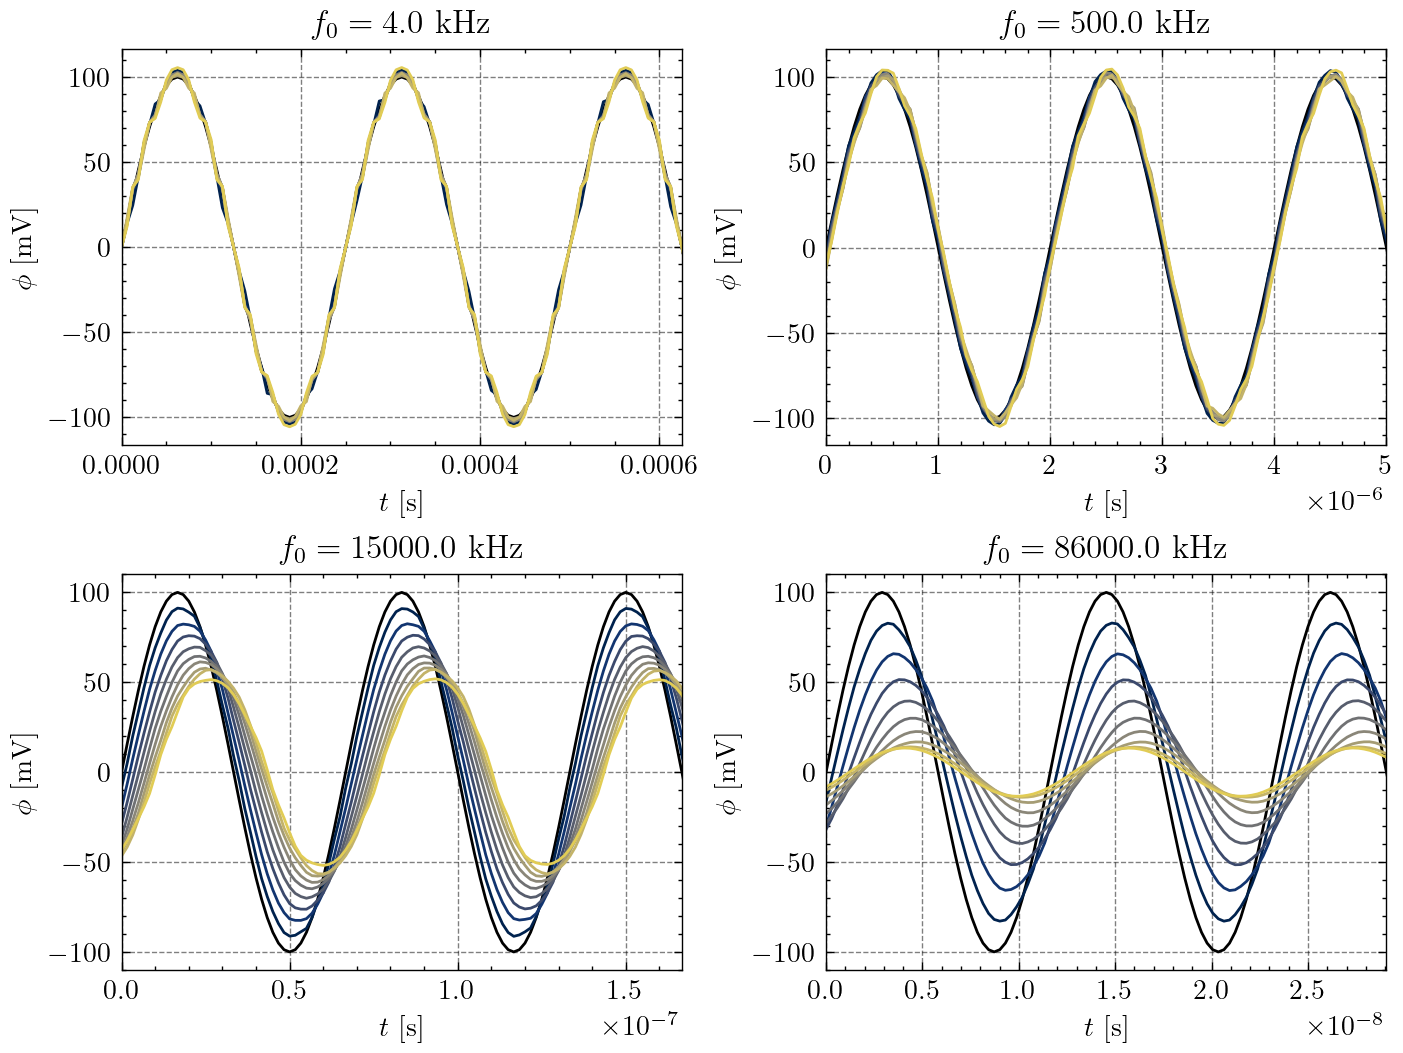

In [8]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*2)

for n, f0 in enumerate([0.004, 0.5, 15., 86.]):
    ax  = fig.add_subplot(2,2,n+1)
    ax.plot(time_data[f0], pot_data[f0]["0"]*1000, c='black')
    for i in range(2, N_NP+2):
        ax.plot(time_data[f0], pot_data[f0][f"{i}"]*1000, c=cm(norm_n(i-2)))
    ax.set_xlim(0, time_data[f0][100])
    ax.set_title(f"$f_0 = {f0*1e3}$ kHz")
    ax.set_xlabel("$t$ [s]")
    ax.set_ylabel("$\phi$ [mV]")
fig.savefig("../plots/ac_input/string/open_phi_vs_time.svg", transparent=True)

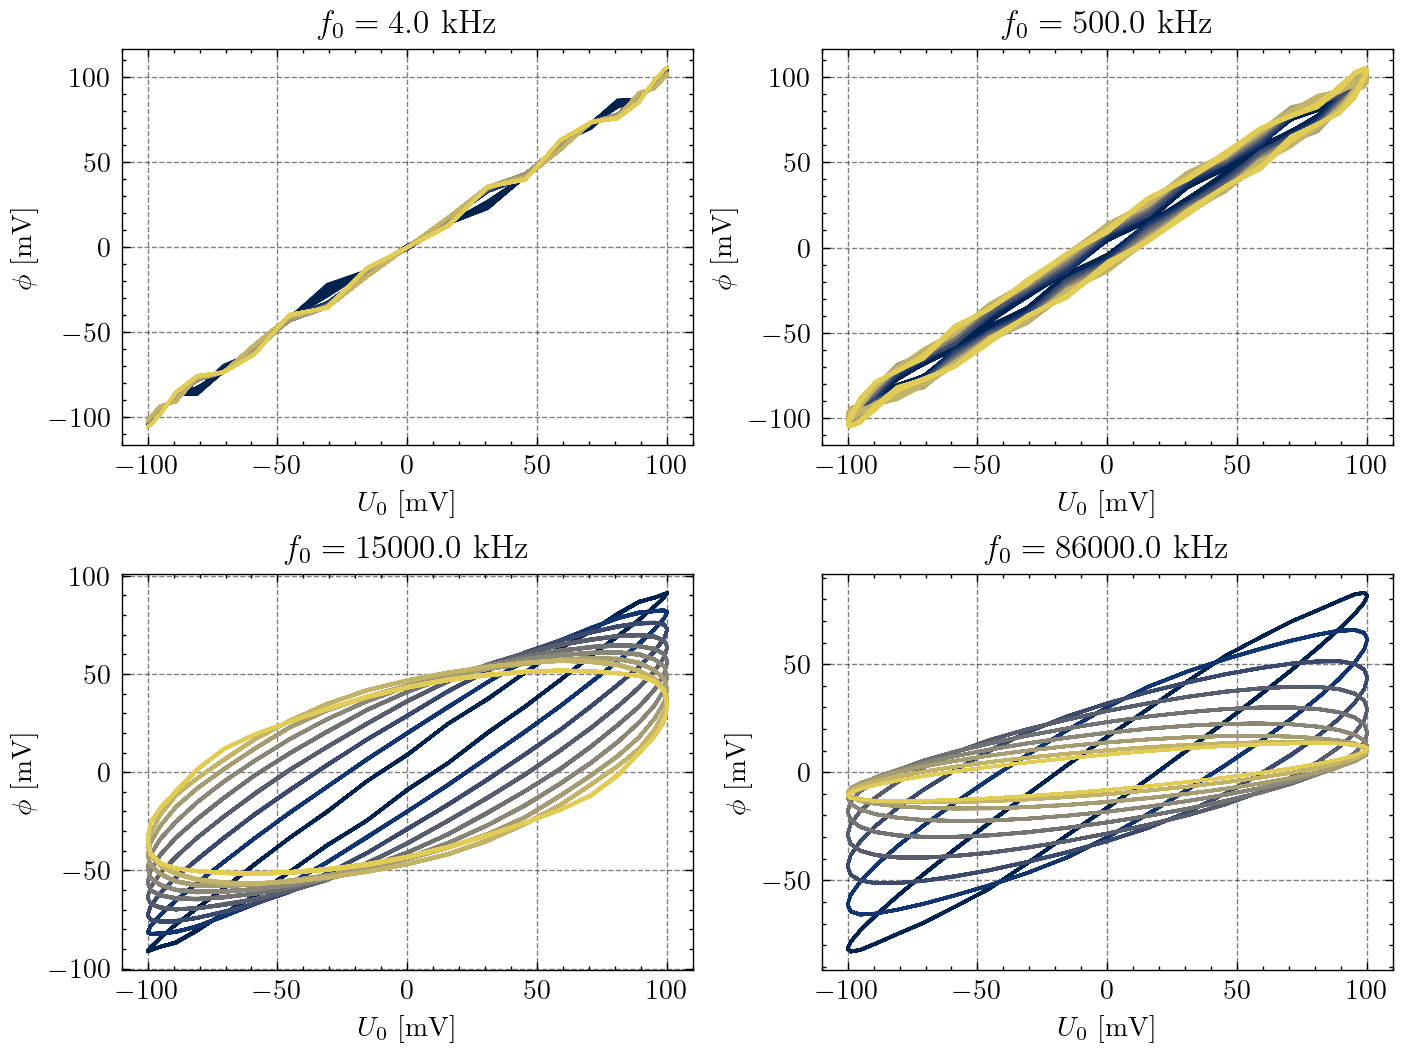

In [9]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*2)

for n, f0 in enumerate([0.004, 0.5, 15., 86.]):
    ax  = fig.add_subplot(2,2,n+1)
    for i in range(2, N_NP+2):
        ax.plot(pot_data[f0]["0"]*1000, pot_data[f0][f"{i}"]*1000, c=cm(norm_n(i-2)))
    ax.set_title(f"$f_0 = {f0*1e3}$ kHz")
    ax.set_xlabel("$U_0$ [mV]")
    ax.set_ylabel("$\phi$ [mV]")
fig.savefig("../plots/ac_input/string/open_phase_space.svg", transparent=True)

In [28]:
N_f         = 18
h_strength  = []
thd         = []
A_f0        = []
phase       = []
freq_fit    = []

for f0 in freq_vals:
    h1  = []
    t1  = []
    A1  = []
    p1  = []
    f1  = []
    p0  = [0.1, f0*1e6, 0, 0]
    for i in range(2,N_NP+2):
        t_val   = time_data[f0]
        y_val   = pot_data[f0].iloc[:,i].values.copy()*1000
        h_temp  = harmonic_strength(signal=y_val, f0=f0*1e6, dt=dt_data[f0], N_f=N_f, n_padded=len(y_val)*10, amplitude_threshold=0)
        xf,yf   = fft(y_val, dt_data[f0], n_padded=len(y_val)*10)
        func    = interp1d(xf, yf)
        A2      = float(func(f0))
        p,_     = curve_fit(sin_func, t_val, y_val, p0=p0, bounds=[(0,f0*1e6-0.1,-np.inf,-np.inf),(0.2,f0*1e6+0.1,np.inf,np.inf)])
        p0      = [p[0],f0*1e6,p[2],p[3]]

        h1.append(h_temp)
        t1.append(np.sqrt(np.sum(np.array(h_temp)**2))*100)
        A1.append(A2)
        f1.append(p[1]/1e6)
        p1.append(p[2])
    A_f0.append(A1)
    h_strength.append(h1)
    thd.append(t1)
    phase.append(p1)
    freq_fit.append(f1)

thd_df  = pd.DataFrame(thd, index=np.round(np.array(freq_vals),4))
A_f0_df = pd.DataFrame(A_f0, index=np.round(np.array(freq_vals),4))
pha_df  = pd.DataFrame(phase, index=np.round(np.array(freq_vals),4))

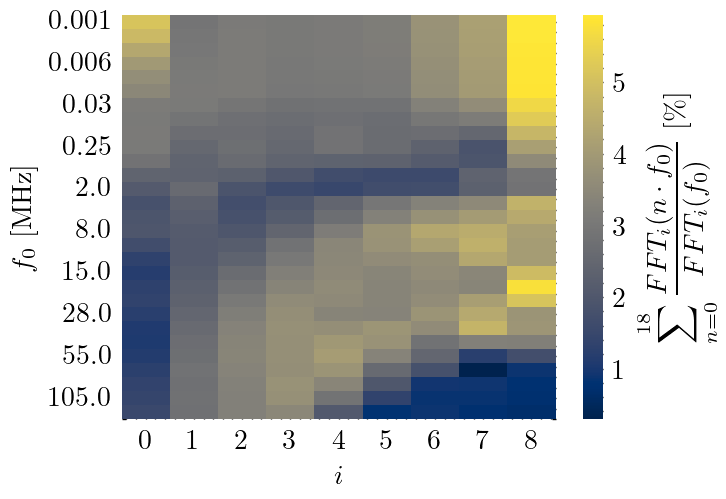

In [29]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(thd_df, cmap='cividis', ax=ax, # center=0, 
                  cbar_kws={"label":"$\displaystyle\sum_{n=0}^{18}\\frac{FFT_i(n \cdot f_0)}{FFT_i(f_0)}$ [\%]"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
fig.savefig("../plots/ac_input/string/open_thd_vs_f0_vs_i.svg", transparent=True)

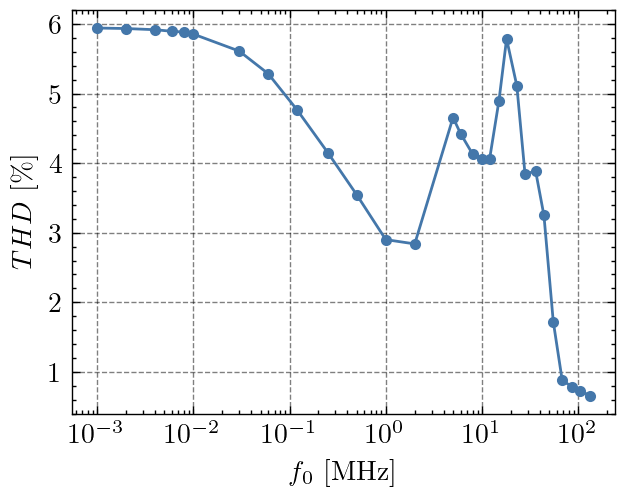

In [30]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(thd_df.index, thd_df[8].values, '.-')
ax.set_ylabel('$THD$ [\%]')
ax.set_xlabel('$f_0$ [MHz]')
ax.set_xscale('log')
fig.savefig(f"../plots/ac_input/string/open_thd.svg", transparent=True)

Text(0.5, 12.31756469338072, '$i$')

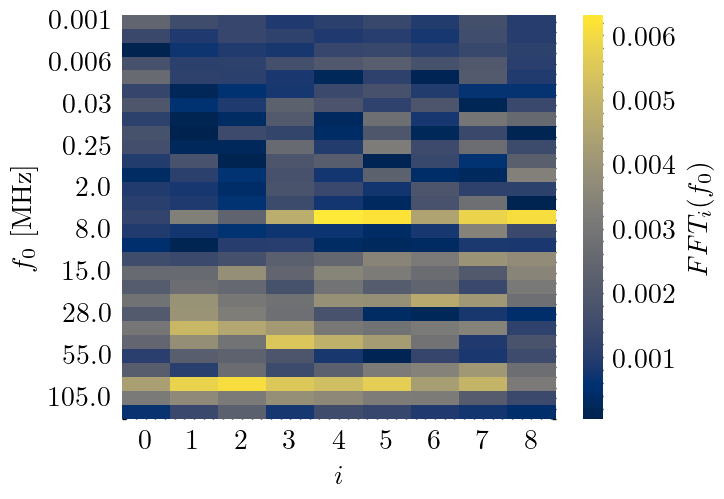

In [22]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(A_f0_df, cmap='cividis', ax=ax, #norm=LogNorm(vmin=50, vmax=2000), #center=0,
                  cbar_kws={"label":"$FFT_i(f_0)$"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
# fig.savefig("../plots/ac_input/string/Af0_vs_f0_vs_i.svg", transparent=True)

Text(0.5, 12.31756469338072, '$i$')

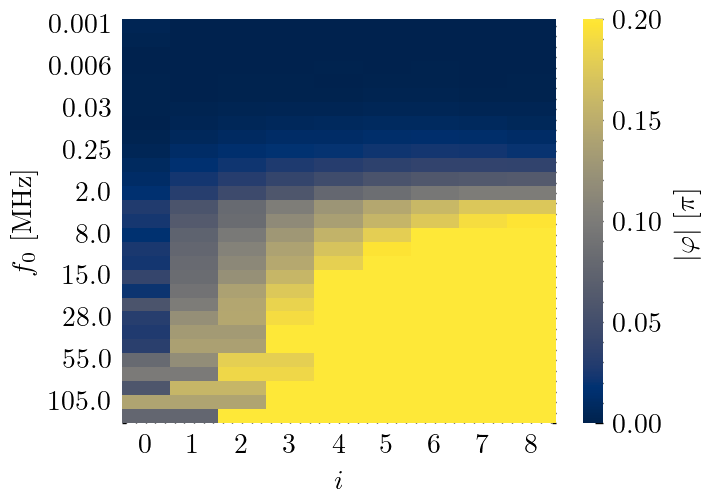

In [24]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(np.abs((pha_df+np.pi)%(2*np.pi)-np.pi)/np.pi, cmap='cividis', ax=ax, vmin=0, vmax=0.2, #center=0, 
                  cbar_kws={"label":"$|\\varphi|$ [$\pi$]"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
# fig.savefig("../plots/ac_input/nonlinear/abs_phase_vs_f0_vs_i.svg", transparent=True)

Text(0.5, 12.31756469338072, '$i$')

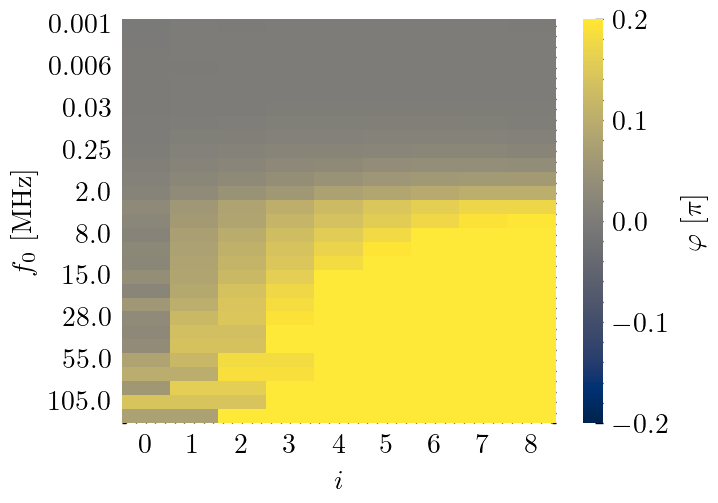

In [26]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(((pha_df+np.pi)%(2*np.pi)-np.pi)/np.pi, cmap='cividis', ax=ax, vmin=-0.2, vmax=0.2, #center=0, 
                  cbar_kws={"label":"$\\varphi$ [$\pi$]"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
# fig.savefig("../plots/ac_input/nonlinear/phase_vs_f0_vs_i.svg", transparent=True)

In [27]:
lam     = []
params  = []
for i in range(len(A_f0_df)):
    p,_ = curve_fit(exp_decay, np.arange(39), A_f0_df.iloc[i,:-1].values, bounds=([0,0,0],[np.inf,np.inf,np.inf]))
    lam.append(p[1])
    params.append(p)

ValueError: operands could not be broadcast together with shapes (39,) (8,) 

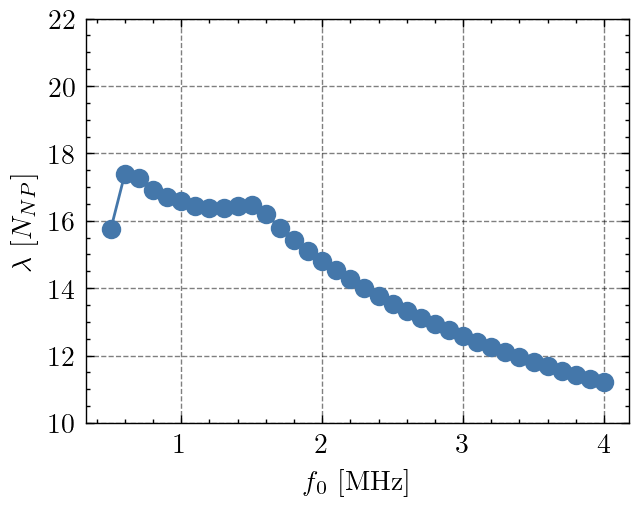

In [18]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(np.array(freq_vals)/1e6, lam, 'o-')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$\lambda$ [$N_{NP}$]")
ax.set_ylim(10,22)
fig.savefig("../plots/ac_input/nonlinear/penetration_depth_vs_f0.svg", transparent=True)

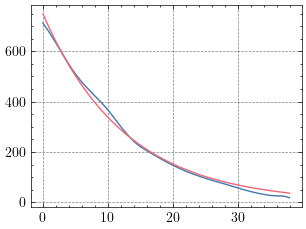

In [28]:
i = 25
plt.plot(A_f0_df.iloc[i,:-1].values)
plt.plot(exp_decay(np.arange(39),*params[i]))

$1 / \tau = 1$ MHz

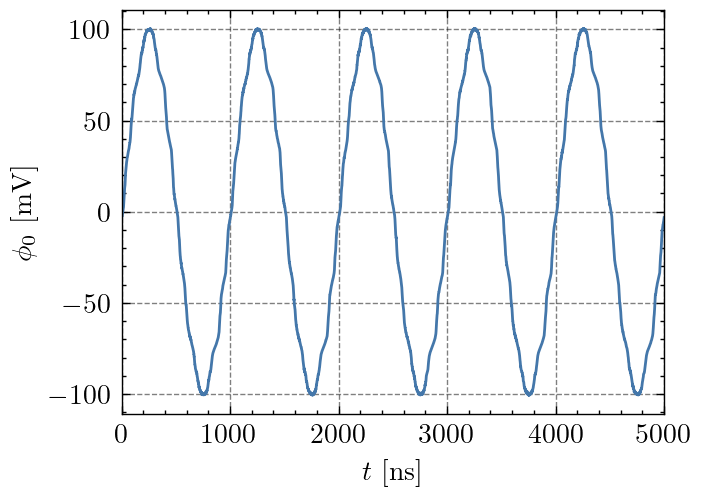

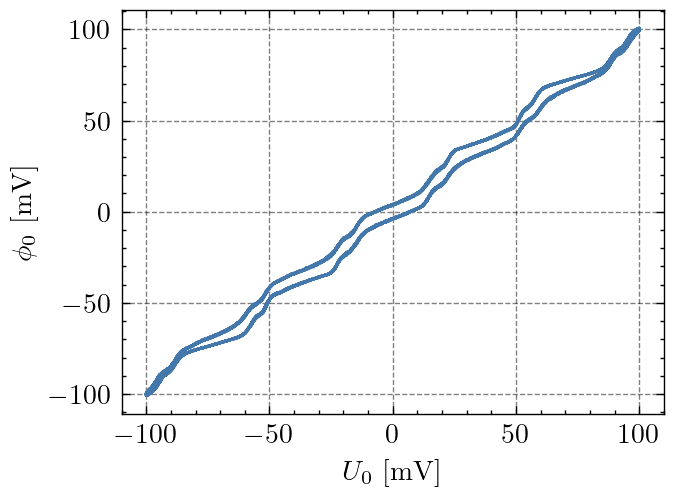

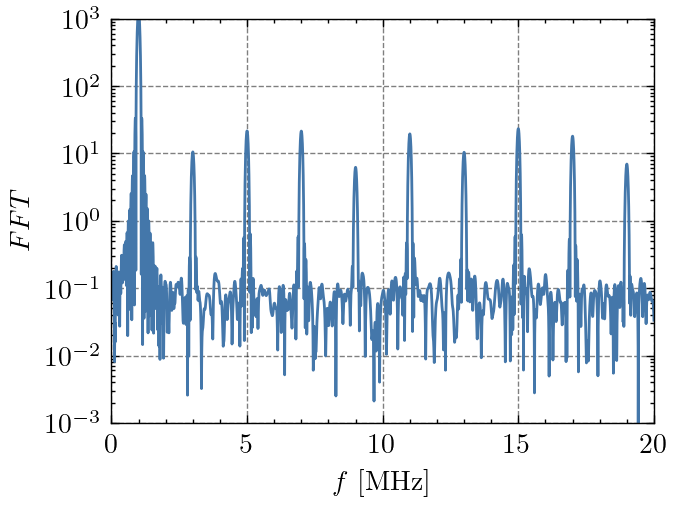

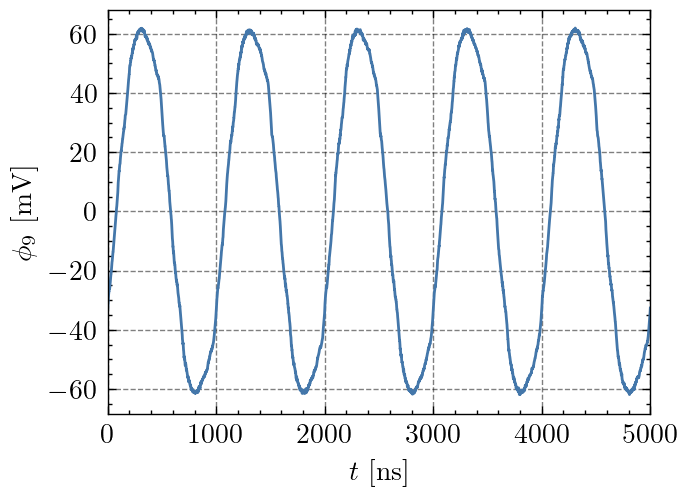

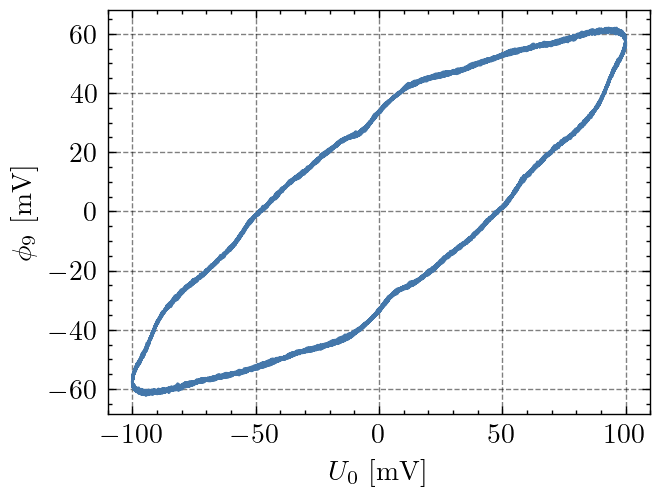

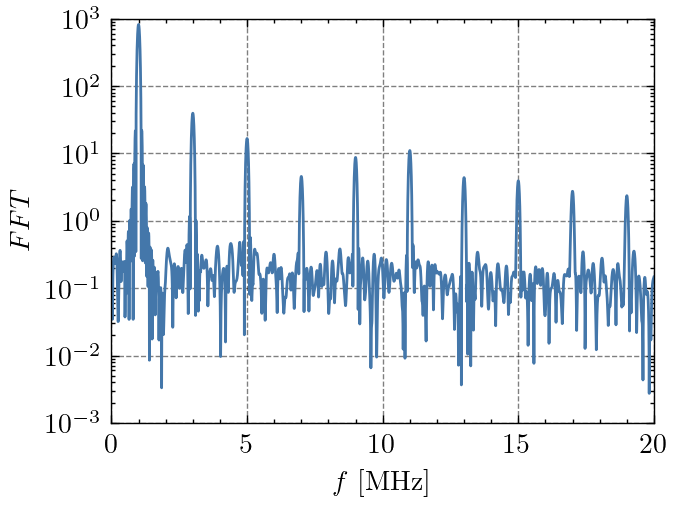

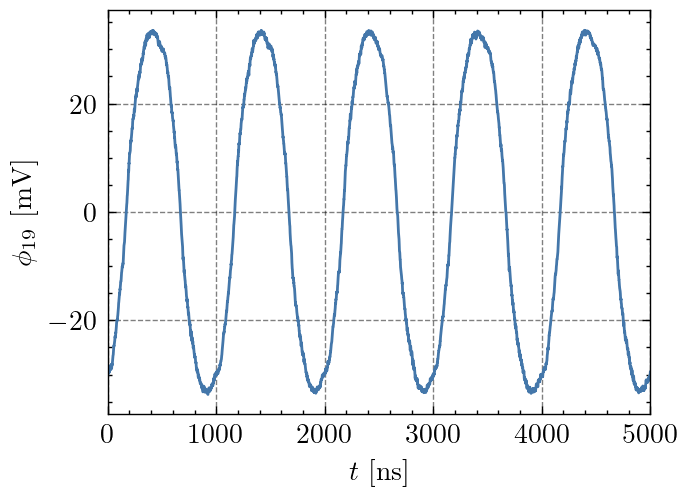

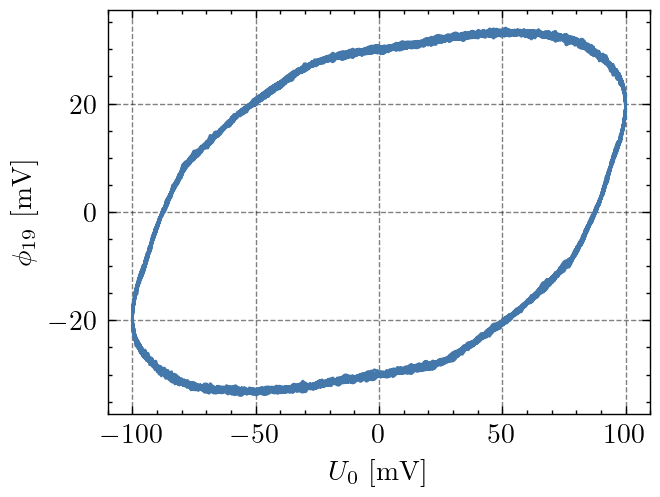

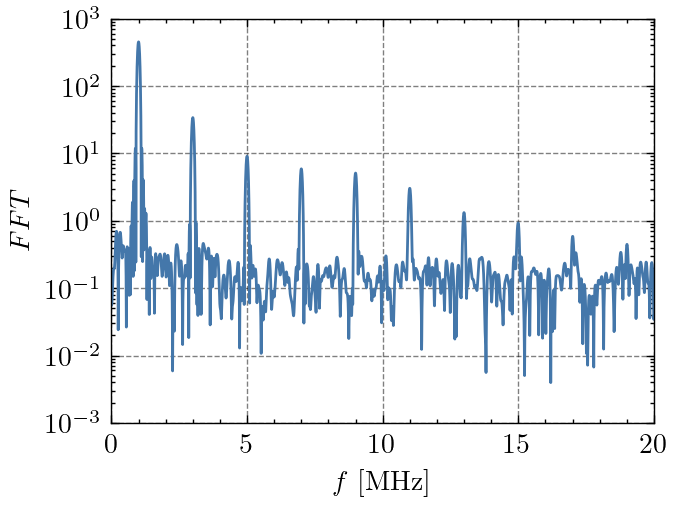

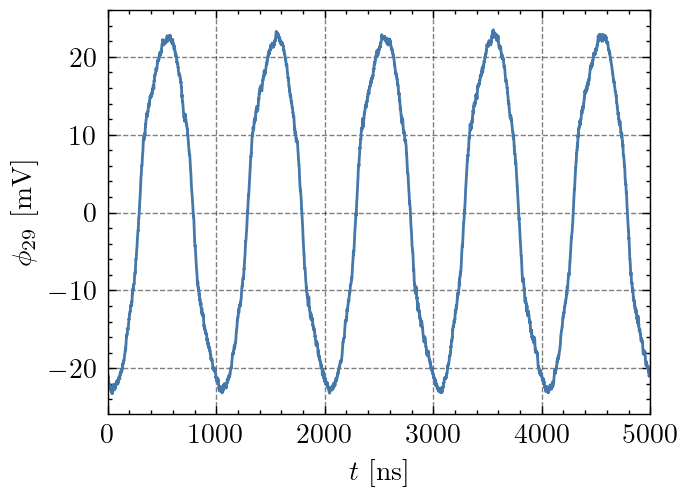

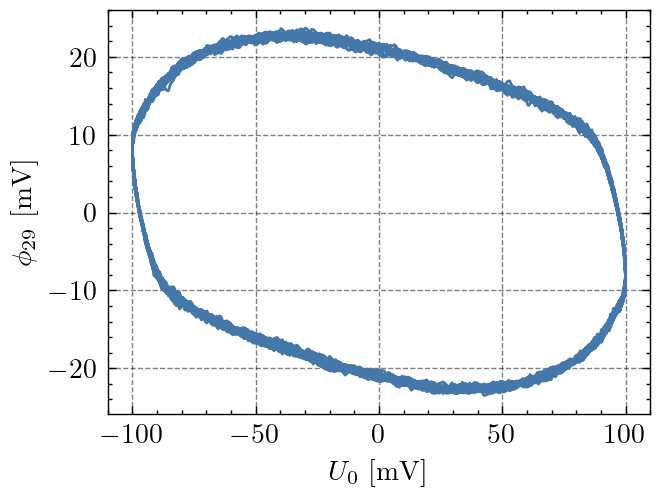

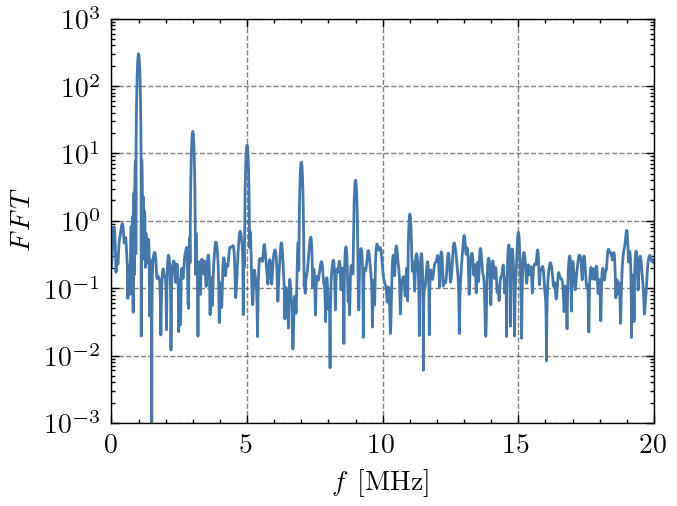

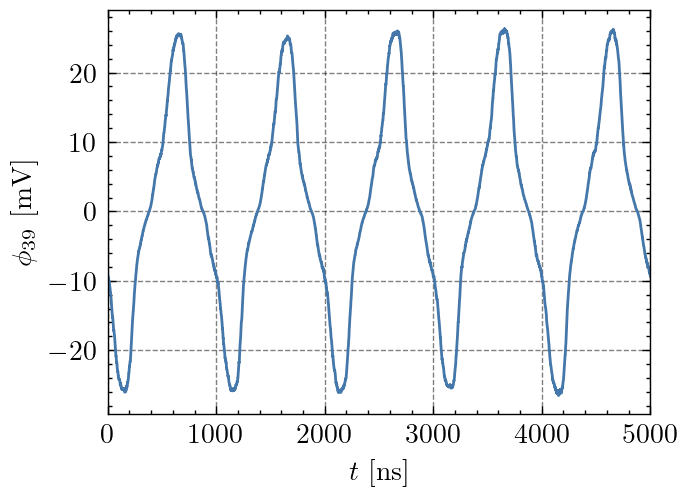

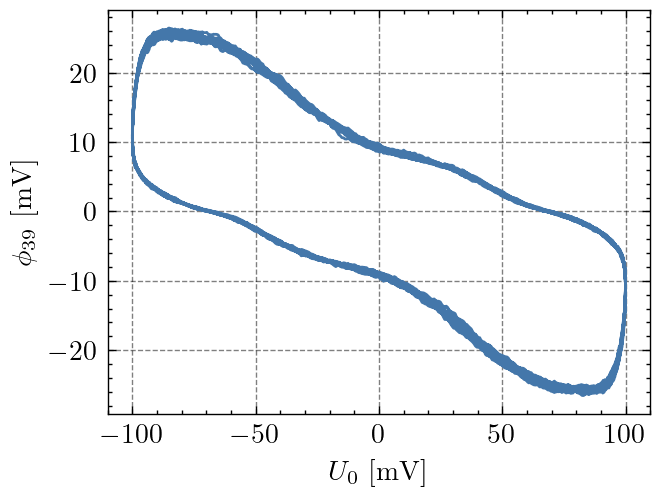

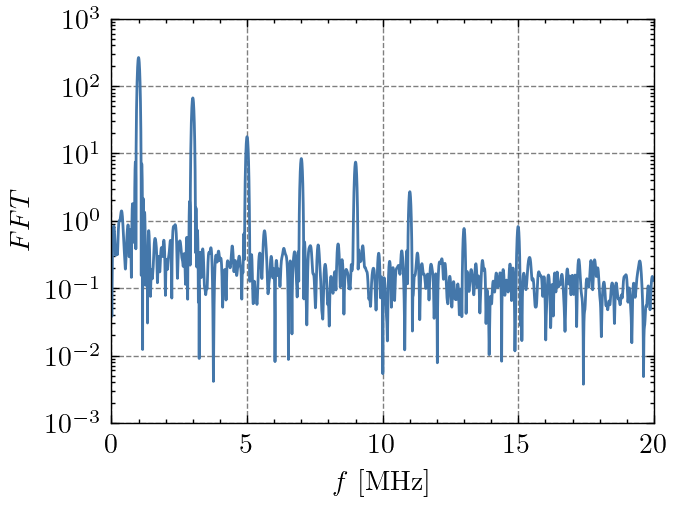

In [32]:
idx = [0,9,19,29,39]
f0  = 1e6

for i in idx:

    fig     = plt.figure(dpi=200)
    ax      = fig.add_subplot()
    t       = time_data[f0]
    y       = pot_data[f0].iloc[:,i].values.copy()*1000
    xf,yf   = nanonets_utils.fft(y, time_step, n_padded=len(y)*10)

    ax.plot(t*1e9, y)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$\phi_{"+f"{i}"+"}$ [mV]")
    ax.set_xlim(0,5000)
    fig.savefig(f"../plots/ac_input/nonlinear/signal/np_{i}_f0_{f0}.svg", transparent=True)

    fig     = plt.figure(dpi=200)
    ax      = fig.add_subplot()
    x       = data[f0].iloc[:,0].values.copy()*1000

    ax.plot(x, y)
    ax.set_xlabel("$U_0$ [mV]")
    ax.set_ylabel("$\phi_{"+f"{i}"+"}$ [mV]")
    fig.savefig(f"../plots/ac_input/nonlinear/phase/np_{i}_f0_{f0}.svg", transparent=True)

    fig     = plt.figure(dpi=200)
    ax      = fig.add_subplot()
    ax.plot(xf/1e6, yf)
    ax.set_xlim(0,20*f0/1e6)
    ax.set_yscale("log")
    ax.set_ylim(1e-3, 1e3)
    ax.set_xlabel("$f$ [MHz]")
    ax.set_ylabel("$FFT$")
    fig.savefig(f"../plots/ac_input/nonlinear/fft/np_{i}_f0_{f0}.svg", transparent=True)

    # ax.set_xlim(0,1000)

(0.0, 20.0)

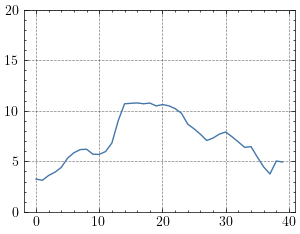

In [31]:
plt.plot(thd_df.iloc[30,:])
plt.ylim(0,20)

In [571]:
sim_class           = nanonets.simulation(topology_parameter=topology_parameter, high_C_output=False)
cap_matrix          = sim_class.capacitance_matrix
inv_cap_matrix      = sim_class.inv_capacitance_matrix

In [573]:
f0  = 1e6
Q_t = np.zeros_like(pot_data[f0].values)
C   = cap_matrix
C_i = inv_cap_matrix
for t in range(pot_data[f0].values.shape[0]):
    Q_t[t, :] = C @ pot_data[f0].values[t, :]

# Total injected charge (relative to t=0)
Q_total = np.sum(Q_t - Q_t[0, :], axis=1)  # Shape: (N_T,)
P       = Q_t[-1, 1:] - Q_t[-1, :-1]

E_t = np.zeros(pot_data[f0].values.shape[0])
for t in range(pot_data[f0].values.shape[0]):
    E_t[t] = 0.5 * Q_t[t, :].T @ C_i @ Q_t[t, :]

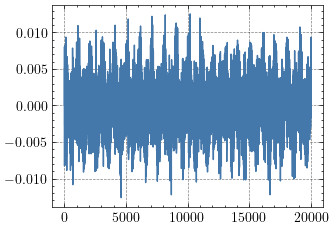

In [584]:
plt.plot(np.diff(Q_t[:,5]))

Text(0, 0.5, '$P_i$')

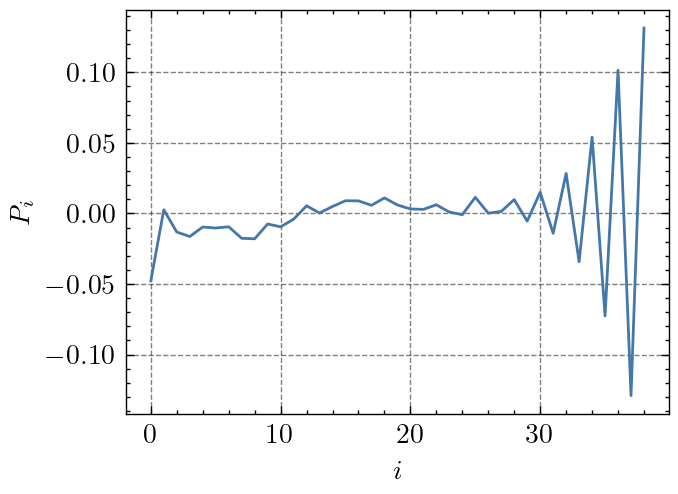

In [574]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(P)
ax.set_xlabel("$i$")
ax.set_ylabel("$P_i$")

Text(0, 0.5, '$Q_{total}$ [C]')

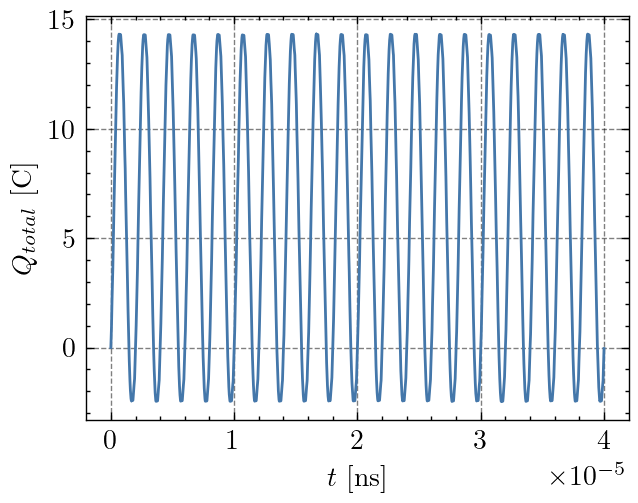

In [336]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(time_data[f0],Q_total)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$Q_{total}$ [C]")

Text(0, 0.5, '$E$ [J]')

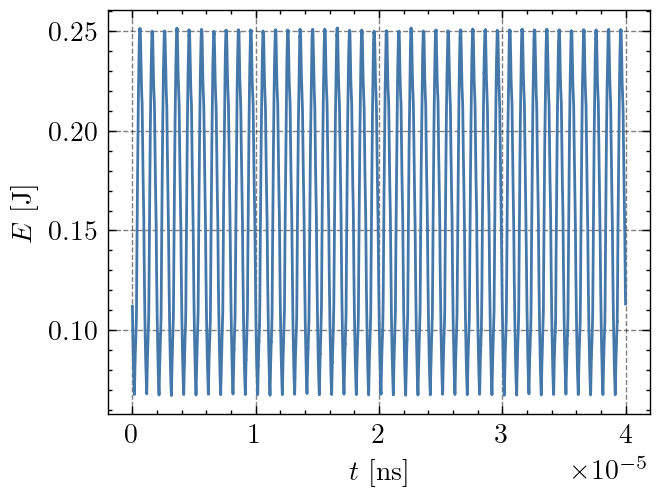

In [337]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(time_data[f0],E_t)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$E$ [J]")

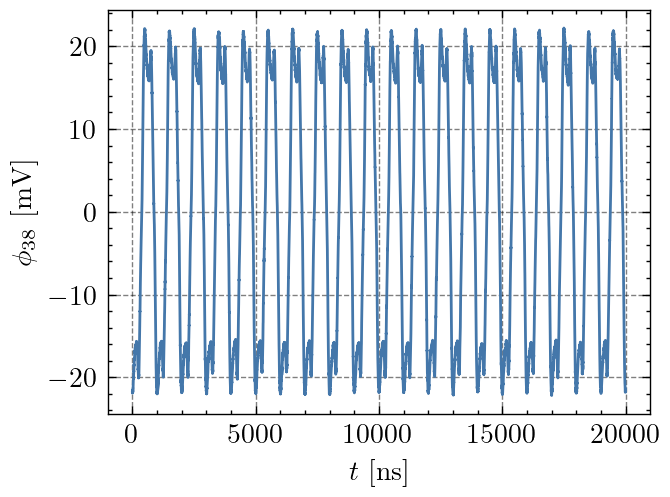

In [351]:
idx = [9,19,29,39]
idx = [38]
f0  = 1e6

for i in idx:

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    t   = time_data[f0]
    y   = pot_data[f0].iloc[:,i].values.copy()*1000

    ax.plot(t*1e9, y)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$\phi_{"+f"{i}"+"}$ [mV]")
    # ax.set_xlim(0,1000)

(0.0, 3000.0)

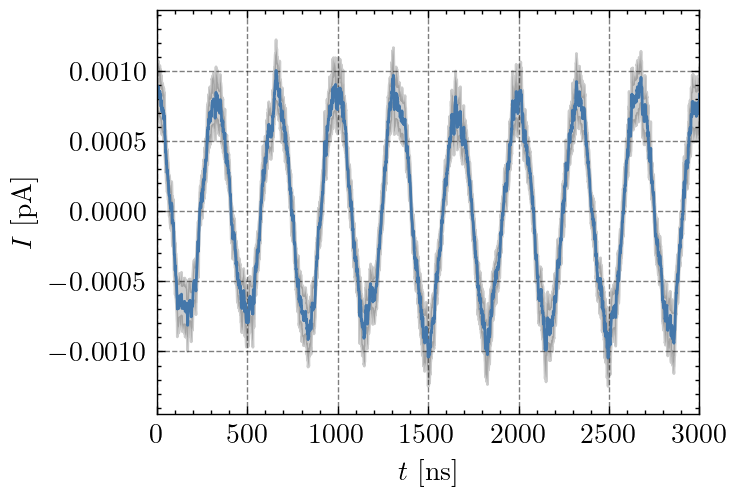

In [259]:
f0  = 5e6
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
t   = time_data[f0]
y   = data[f0].loc[:,'Current'].values.copy()
y_e = data[f0].loc[:,'Error'].values.copy()

ax.plot(t*1e9, y)
ax.fill_between(t*1e9, y-y_e, y+y_e, color='black', alpha=0.2)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$I$ [pA]")
ax.set_xlim(0,3000)

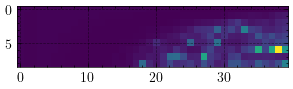

In [189]:
plt.imshow(thd_df)

Text(0, 0.5, '$\\phi_i(t)/U_0$')

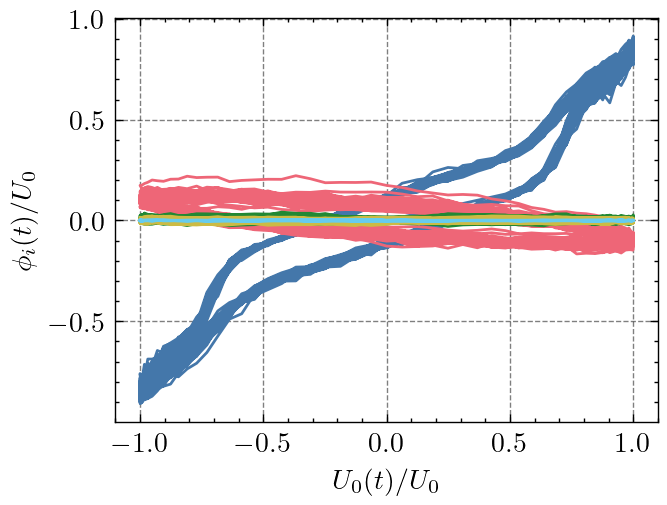

In [121]:
idx = [0,9,20,30,39]
f0  = 10e6
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for i in idx:
    y   = pot_data[f0].iloc[:,i].values.copy()/U0
    t   = np.arange(len(y))*time_step
    ax.plot(sin_func(t, U0, f0, 0, 0)/U0, y)
ax.set_xlabel("$U_0(t)/U_0$")
ax.set_ylabel("$\phi_i(t)/U_0$")

In [4]:
for f0 in f_vals:

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    t_val   = t_vals.copy() 
    x_val   = data_string[f0]['E0'].values[-10000:]*1000
    y_val   = data_string[f0]['Current'].values[-10000:]*1000
    y_err   = data_string[f0]['Error'].values[-10000:]*1000
    ax.plot(x_val, y_val)
    ax.fill_between(x_val, y_val-y_err, y_val+y_err, alpha=0.2, color='black')
    ax.set_xlabel("$U_0$ [mV]", fontsize='x-large')
    ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')

    fig.savefig(f"../plots/ac_input/phase_space/{f0}.svg", transparent=True)
    fig.savefig(f"../plots/ac_input/phase_space/{f0}.pdf", transparent=False)
    plt.close(fig)

In [5]:
for f0 in f_vals:

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    t_val   = t_vals[f0].copy()
    x_val   = data_string[f0]['E0'].values[-10000:]*1000
    y_val   = data_string[f0]['Current'].values[-10000:]*1000
    y_err   = data_string[f0]['Error'].values[-10000:]*1000
    ax.plot(t_val, y_val)
    ax.fill_between(t_val, y_val-y_err, y_val+y_err, alpha=0.2, color='black')
    ax.set_xlabel("$U_0$ [mV]", fontsize='x-large')
    ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')

    fig.savefig(f"../plots/ac_input/signal/{f0}.svg", transparent=True)
    fig.savefig(f"../plots/ac_input/signal/{f0}.pdf", transparent=False)
    plt.close(fig)

In [6]:
for f0 in f_vals:

    t_val   = t_vals[f0].copy()
    x_val   = data_string[f0]['E0'].values*1000
    y_val   = data_string[f0]['Current'].values*1000
    y_val   = y_val-np.mean(y_val)
    t_step  = time_step[f0]
    xf, yf  = nanonets_utils.fft(signal=y_val, dt=t_step, n_padded=16384)
    xf      = xf / 1e6
    y_min   = 1e-3
    y_max   = 1e4

    fig = plt.figure(dpi=250)
    ax  = fig.add_subplot()
    ax.plot(xf, yf)

    ax.set_yscale('log')
    ax.set_xlim(0,20*f0)
    ax.set_ylim(y_min,y_max)
    ax.set_xlabel("$f$ [MHz]", fontsize='x-large')
    ax.set_ylabel("$FFT$", fontsize='x-large')
    # ax.legend(fontsize='xx-small', loc='upper right', ncol=3)
    fig.savefig(f"../plots/ac_input/fft/{f0}.svg", transparent=True)
    plt.close(fig)

In [7]:
N_f         = 50
h_strength  = []
end         = 5

for f0 in freq_vals[:-end]:
    y_val   = data_string[f0]['Current'].values*1000
    t_step  = time_step[f0]
    h_temp  = nanonets_utils.harmonic_strength(signal=y_val, f0=f0*1e6, dt=t_step, N_f=N_f, n_padded=16384, dB=False)
    h_strength.append(h_temp)

h_df    = pd.DataFrame(h_strength, columns=np.arange(2,N_f+2), index=f_vals[:-end])
thd_v   = np.sqrt(np.sum(np.array(h_strength)**2, axis=1))*100
h_df

,2,3,4,5,6,7,8,9,10,11,...,42,43,44,45,46,47,48,49,50,51
0.001,0.000004,0.024307,0.000004,0.031235,0.000003,0.030476,0.000014,0.005560,0.000004,0.033460,...,0.000004,0.001060,0.000005,0.000434,0.000005,0.001934,0.000008,0.000742,0.000005,0.000128
0.002,0.000012,0.024288,0.000009,0.031221,0.000006,0.030428,0.000005,0.005568,0.000013,0.033400,...,0.000003,0.001039,0.000016,0.000583,0.000010,0.001886,0.000009,0.000816,0.000012,0.000123
0.004,0.000010,0.024239,0.000004,0.031208,0.000022,0.030321,0.000018,0.005609,0.000005,0.033266,...,0.000008,0.001009,0.000009,0.000746,0.000004,0.001771,0.000013,0.000887,0.000012,0.000255
0.006,0.000021,0.024229,0.000019,0.031164,0.000021,0.030197,0.000015,0.005643,0.000014,0.033120,...,0.000031,0.000978,0.000024,0.000814,0.000012,0.001594,0.000016,0.000856,0.000007,0.000278
0.008,0.000013,0.024116,0.000012,0.031172,0.000009,0.030091,0.000021,0.005698,0.000016,0.032981,...,0.000033,0.000946,0.000039,0.000834,0.000015,0.001420,0.000007,0.000851,0.000016,0.000266
0.010,0.000016,0.024073,0.000028,0.031093,0.000021,0.029989,0.000034,0.005659,0.000024,0.032775,...,0.000003,0.000852,0.000024,0.000839,0.000026,0.001335,0.000006,0.000941,0.000021,0.000312
0.020,0.000039,0.023721,0.000038,0.030762,0.000056,0.029549,0.000004,0.005847,0.000039,0.031710,...,0.000056,0.001045,0.000004,0.000883,0.000034,0.001988,0.000039,0.001942,0.000014,0.000735
0.040,0.000028,0.023108,0.000022,0.030050,0.000063,0.029013,0.000044,0.006151,0.000022,0.030062,...,0.000032,0.001860,0.000017,0.000834,0.000020,0.003402,0.000051,0.002870,0.000030,0.000918
0.060,0.000059,0.022915,0.000059,0.029511,0.000055,0.028704,0.000109,0.006489,0.000069,0.029082,...,0.000044,0.002320,0.000010,0.000608,0.000016,0.003972,0.000018,0.003095,0.000029,0.000968
0.080,0.000074,0.022923,0.000035,0.029132,0.000050,0.028461,0.000021,0.006763,0.000041,0.028611,...,0.000023,0.002483,0.000025,0.000577,0.000024,0.004255,0.000022,0.003273,0.000013,0.001080


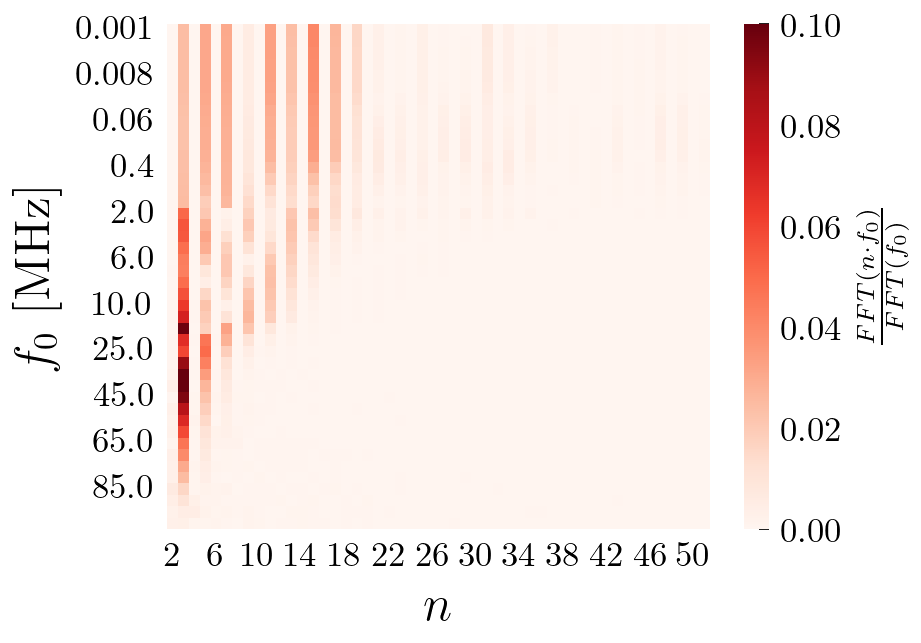

In [12]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax  = sns.heatmap(h_df, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$"}, vmin=0, vmax=0.1)
ax.set_ylabel('$f_0$ [MHz]', fontsize='x-large')
ax.set_xlabel("$n$", fontsize='x-large')
plt.yticks(rotation=0)
fig.savefig(f"../plots/harmonic_strength.svg", transparent=True)

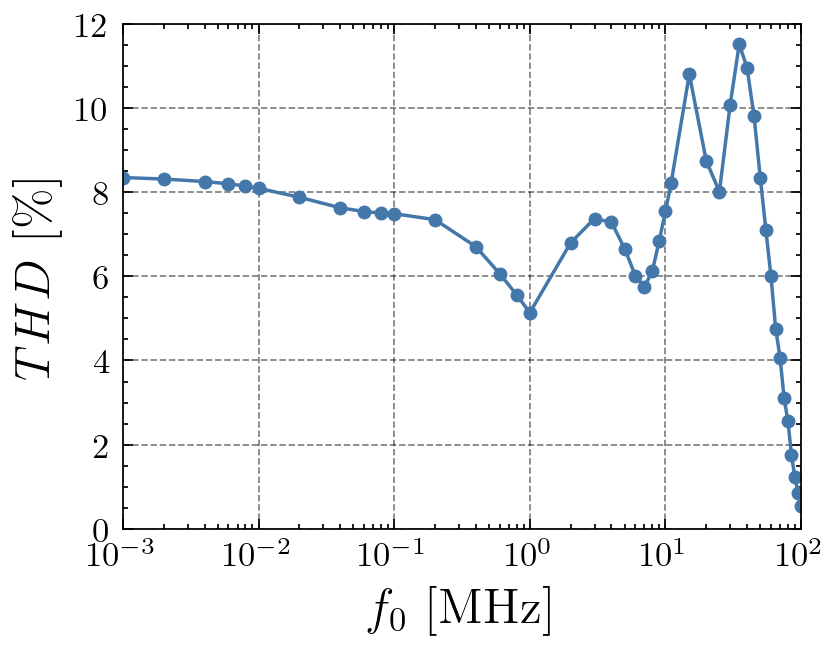

In [13]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax.plot(f_vals[:-end], thd_v, '.-')
ax.set_ylabel('$THD$ [\%]', fontsize='x-large')
ax.set_xlabel('$f_0$ [MHz]', fontsize='x-large')
ax.set_xscale('log')
ax.set_xlim(1e-3,1e2)
ax.set_ylim(0,12)
fig.savefig(f"../plots/thd.svg", transparent=True)

In [14]:
phis    = []
params  = []
for f0 in f_vals[:-end]:
    t       = t_vals[f0]
    y       = data_string[f0]['Current'].values.copy()
    p, cov  = curve_fit(sin_func, t, y, p0=[0.1,f0*1e6,0,0])
    params.append(p)
    phis.append(p[2])

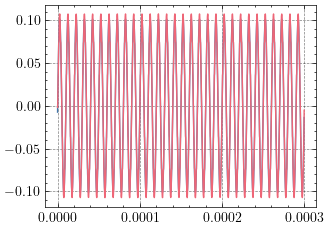

In [15]:
i   = 10
plt.plot(t_vals[f_vals[i]], sin_func(t_vals[f_vals[i]],*params[i]))
plt.plot(t_vals[f_vals[i]], data_string[f_vals[i]]['Current'].values)

Text(0, 0.5, '$\\phi$ [rad]')

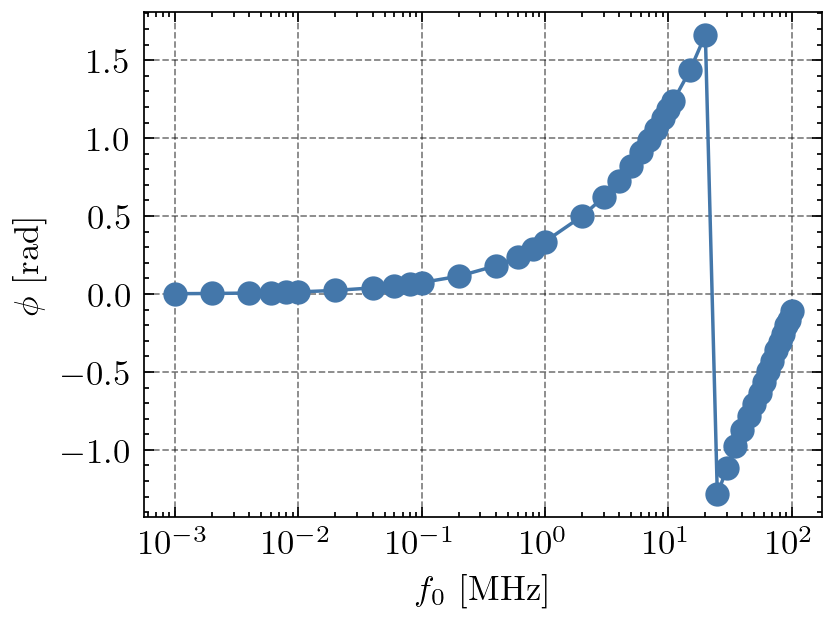

In [16]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax.plot(f_vals[:-end], phis, 'o-')
ax.set_xscale('log')
ax.set_xlabel('$f_0$ [MHz]')
ax.set_ylabel('$\phi$ [rad]')

---

In [81]:
N_samples   = 100
eq_steps    = 10000
time_step   = 1e-10
folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/frequency_modulation/"
dic_sample  = {i : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{i}.csv").iloc[eq_steps:,:].reset_index(drop=True) for i in range(N_samples)}
time_vals   = np.arange(len(dic_sample[0]))*time_step

In [82]:
phis    = []
t       = time_vals.copy()
for key, df in dic_sample.items():
    y       = df['Current'].values.copy()
    p, cov  = curve_fit(sin_func, t, y, p0=[0.1,3.5e6,0,0])
    phis.append(p[2])

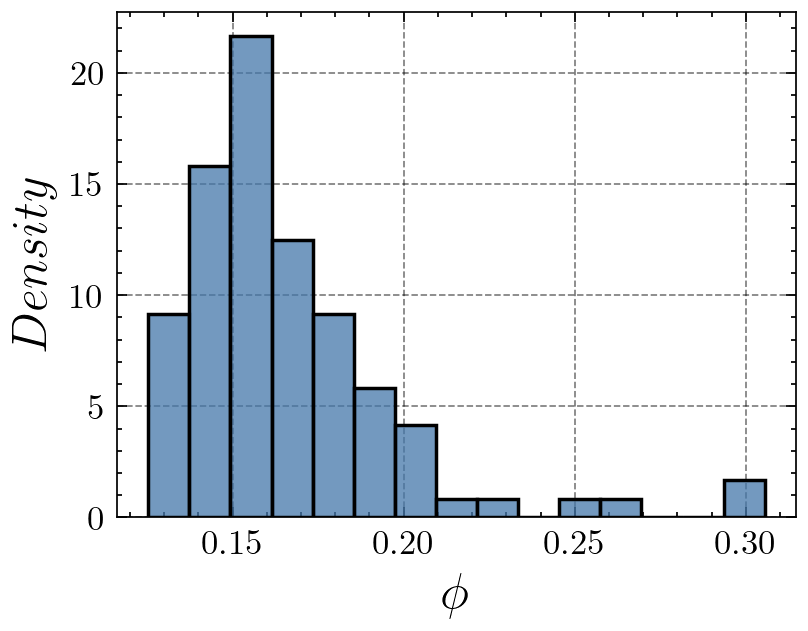

In [83]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax  = sns.histplot(phis, stat='density')

ax.set_xlabel("$\phi$", fontsize='x-large')
ax.set_ylabel("$Density$", fontsize='x-large')

fig.savefig(f"../plots/phase_shift.svg", transparent=True)

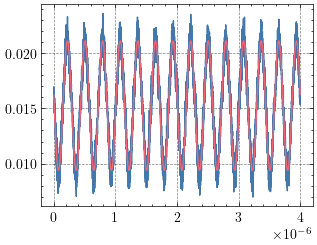

In [86]:
plt.plot(time_vals, y)
plt.plot(time_vals, sin_func(time_vals,*p))

In [19]:
f0  = 3.5*1e6
n_p = 100000
N_f = 5
yff = []
hss = []

for i in range(N_samples):

    y       = dic_sample[i]['Current'].values*1000
    y       = y - np.mean(y)
    xf, yf  = nanonets_utils.fft(signal=y, dt=time_step, n_padded=n_p)
    hs      = nanonets_utils.harmonic_strength(signal=y, f0=f0, dt=time_step, N_f=N_f, n_padded=n_p)
    yff.append(yf)
    hss.append(hs)

h_strength_sample   = pd.DataFrame(hss, columns=np.arange(2,N_f+2))
thd_sample          = np.sqrt(np.sum(np.array(hss)**2, axis=1))
min_sample          = np.argsort(thd_sample)[0]
max_sample          = np.argsort(thd_sample)[-1]
h_strength_sample

,2,3,4,5,6
0,0.031521,0.080547,0.024726,0.019260,0.015649
1,0.039464,0.064459,0.031017,0.008570,0.016402
2,0.138001,0.028641,0.025404,0.013650,0.008148
3,0.067259,0.089079,0.019237,0.006873,0.014499
4,0.039278,0.107450,0.004690,0.017823,0.013399
...,...,...,...,...,...
95,0.133367,0.077685,0.012653,0.022592,0.003677
96,0.199478,0.105522,0.006907,0.020671,0.000774
97,0.085274,0.037564,0.026091,0.023570,0.002736
98,0.108032,0.071995,0.017893,0.008263,0.011699


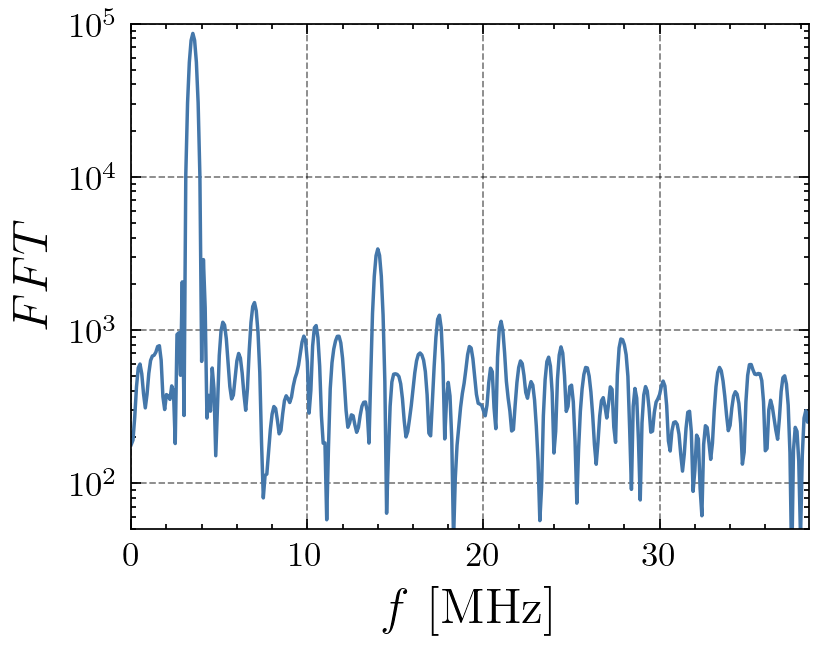

In [252]:
y_min   = 5e1
y_max   = 1e5

fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax.plot(xf/1e6, yff[min_sample])

ax.set_xlim(0,11*f0/1e6)
ax.set_yscale('log')
ax.set_ylim(y_min,y_max)
ax.set_xlabel("$f$ [MHz]", fontsize='x-large')
ax.set_ylabel("$FFT$", fontsize='x-large')

fig.savefig(f"../plots/fft_min_sample.svg", transparent=True)

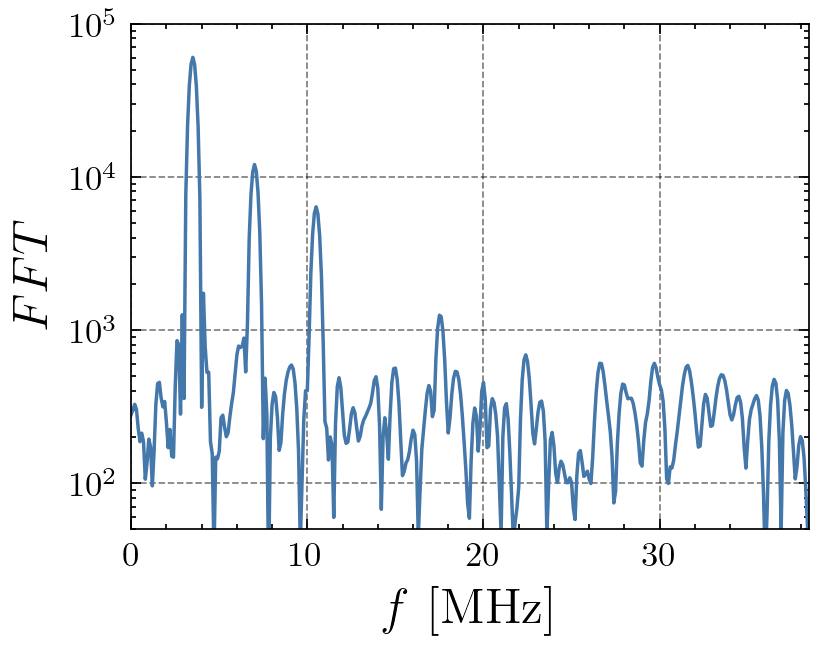

In [253]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax.plot(xf/1e6, yff[max_sample])

ax.set_xlim(0,11*f0/1e6)
ax.set_yscale('log')
ax.set_ylim(y_min,y_max)
ax.set_xlabel("$f$ [MHz]", fontsize='x-large')
ax.set_ylabel("$FFT$", fontsize='x-large')

fig.savefig(f"../plots/fft_max_sample.svg", transparent=True)

Text(0, 0.5, '$U_7(t)$ [mV]')

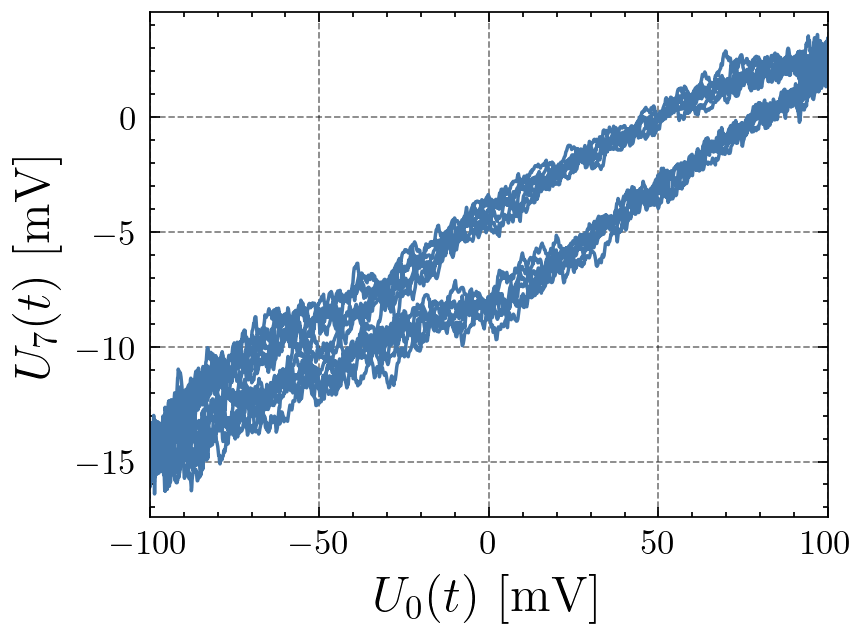

In [254]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
df  = dic_sample[min_sample].iloc[20000:]
ax.plot(df['E0']*1000, df['Current']*1000)
ax.set_xlim(-100,100)
ax.set_xlabel('$U_0(t)$ [mV]', fontsize='x-large')
ax.set_ylabel('$U_7(t)$ [mV]', fontsize='x-large')

# ax.set_xlim(0,11*f0/1e6)
# ax.set_yscale('log')
# ax.set_ylim(y_min,y_max)
# ax.set_xlabel("$f$ [MHz]", fontsize='x-large')
# ax.set_ylabel("$FFT$", fontsize='x-large')

# fig.savefig(f"../plots/phase_space_sample_1.svg", transparent=True)

Text(0, 0.5, '$U_7(t)$ [mV]')

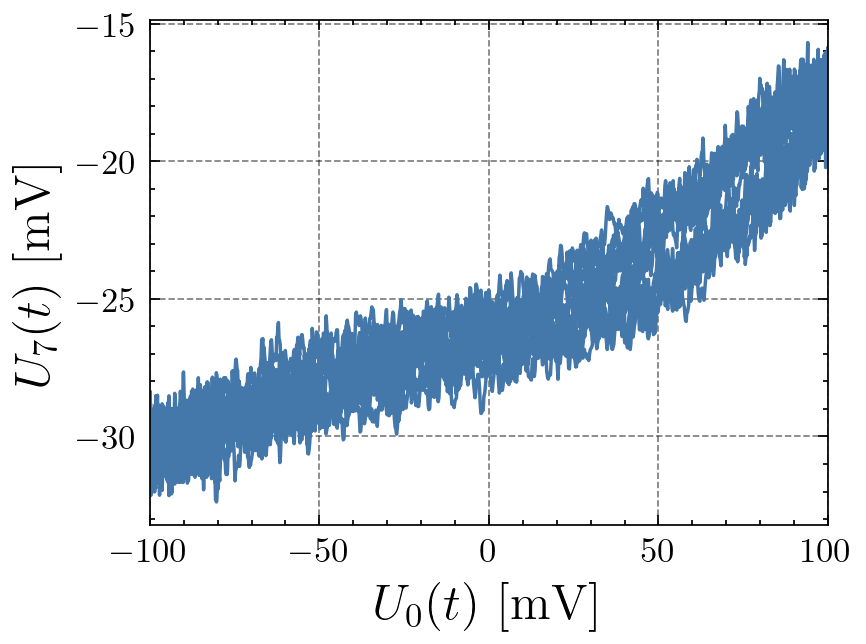

In [255]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
df  = dic_sample[max_sample].iloc[20000:]
ax.plot(df['E0']*1000, df['Current']*1000)
ax.set_xlim(-100,100)
ax.set_xlabel('$U_0(t)$ [mV]', fontsize='x-large')
ax.set_ylabel('$U_7(t)$ [mV]', fontsize='x-large')

# fig.savefig(f"../plots/phase_space_sample_2.svg", transparent=True)

Text(0, 0.5, '$U_7(t)$ [mV]')

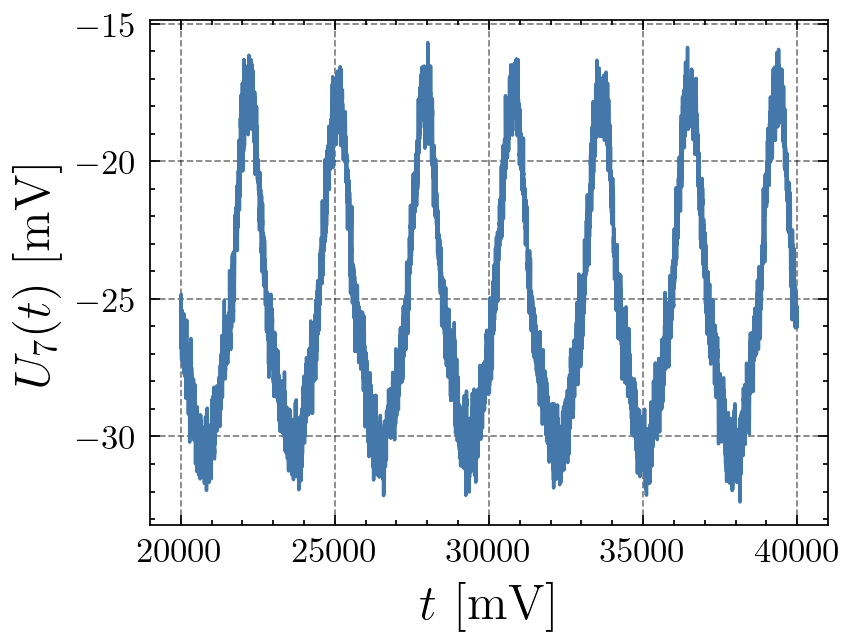

In [257]:
i = max_sample

fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
df  = dic_sample[i].iloc[20000:]
# ax.plot(t_vals[20000:], df['Current']*1000)
ax.plot(df['Current']*1000)
ax.set_xlabel('$t$ [mV]', fontsize='x-large')
ax.set_ylabel('$U_7(t)$ [mV]', fontsize='x-large')

# fig.savefig(f"../plots/phase_space_sample_2.svg", transparent=True)

---

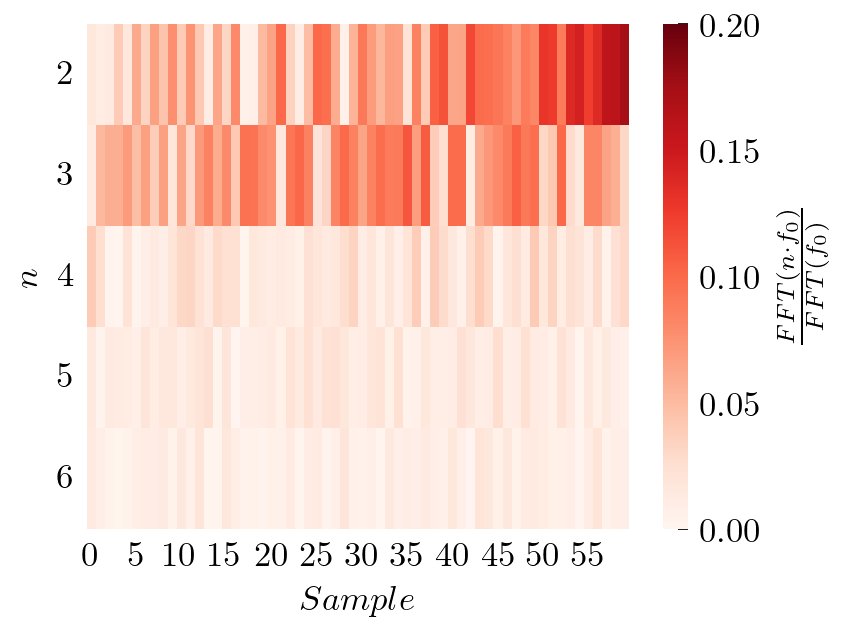

In [191]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax  = sns.heatmap(h_strength_sample.iloc[np.argsort(thd_sample),:].reset_index(drop=True).T, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$"}, vmin=0, vmax=0.2)
ax.set_xlabel('$Sample$')
ax.set_ylabel("$n$")
plt.yticks(rotation=0)
fig.savefig(f"../plots/harmonic_strength_sample.svg", transparent=True)

---

In [129]:
# Global
N_voltages  = 50000
N_samples   = 500
time_step   = 1e-10
stat_size   = 100
time_steps  = np.arange(N_voltages)*time_step
folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/frequency_modulation/"
# folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/frequency_modulation/"

N_p                 = 9
topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : N_p,
        "Nz"                : 1,
        "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],
                            [0,(N_p-1)//2,0],[N_p-1,(N_p-1)//2,0],
                            [0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
        "electrode_type"    : ['constant','constant','constant','constant',
                            'constant','constant','constant','constant']
}

# String
frequencies     = [3.5*1e6,0,0,0,0,0,0,0]
amplitudes      = [0.1,0,0,0,0,0,0,0]
offsets         = np.round(np.random.uniform(-0.1,0.1,(N_samples,8)),4)
offsets[:,0]    = 0.0
offsets[:,-1]   = 0.0
N_processes     = 10
procs           = []

offset              = offsets[0,:]
time_steps, volt    = nanonets_utils.sinusoidal_voltages(N_voltages, topology_parameter, amplitudes=amplitudes, frequencies=frequencies, time_step=time_step, offset=offset)

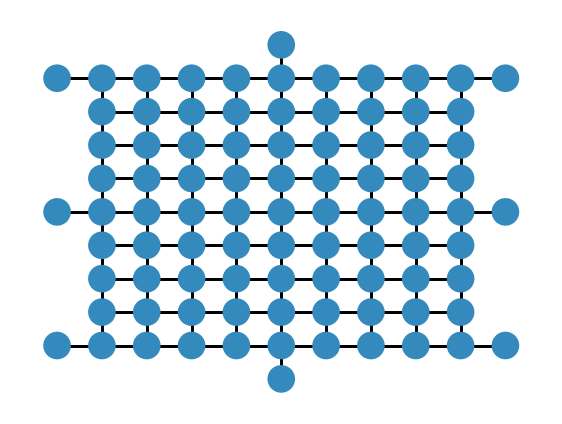

In [131]:
sim_class   = nanonets.simulation(topology_parameter, high_C_output=False)


fig, ax     = plt.subplots(dpi=200)
fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=80)

fig.savefig("../plots/network.svg", transparent=True, bbox_inches='tight')